### Example CNN for Audio

In this notebook, we will show how to create a simple CNN for
audio classification, using the spoken digits database. 

An excellent resource for CNNs is chapter 14 of "Hands-on Machine Learning...." by Geron:

https://www.knowledgeisle.com/wp-content/uploads/2019/12/2-Aur%C3%A9lien-G%C3%A9ron-Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-Tensorflow_-Concepts-Tools-and-Techniques-to-Build-Intelligent-Systems-O%E2%80%99Reilly-Media-2019.pdf



In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import librosa, librosa.display
from IPython.display import Audio
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

from scipy import signal

from scipy.signal import find_peaks

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%matplotlib inline

# Basic audio parameters

SR            = 22050                  #  sample rate default for Librosa

# Utility functions

# Round to 4 decimal places

def round4(x):
    return np.around(x,4)  

# normalize a signal so that its max = 1.0

def normalize(x):
    return x / max(abs(x))

In [5]:
import soundfile as sf
import io
import warnings

from six.moves.urllib.request import urlopen

def readSignal(name,sr=None):    
    if(name[:5] == 'https'):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X, fileSR = sf.read(io.BytesIO(urlopen(name).read()))           
    else:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X, fileSR = librosa.load(name)
    if((sr == None) or (fileSR == sr)):
        return X
    else:
        return librosa.resample(X,fileSR,SR) 

# write signal array out to a file in your local directory (or to complete path name)

def writeSignal(name,data,sr=SR):
    sf.write(name,data,sr)

In [6]:
# Display 


def displaySignal(X, sr=SR, title='Signal Window for X',x_units = "Seconds", figsize=(14,6),gridlines=False): 
    
    if(x_units == "Seconds"):
        T = np.arange(0, len(X)/sr, 1/sr)
    elif(x_units == "Milliseconds"):
        T = np.arange(0, 1000*len(X)/sr, 1000/sr)
    elif(x_units == "Samples"):
        T = np.arange(len(X))

    plt.figure(figsize=figsize)   # Set x and y dimensions of window: may need to redo for your display
    plt.title(title, fontsize=14, fontweight='bold')
    if(x_units=="Samples"):
        plt.xlabel("Sample Number")
    else:
        plt.xlabel(x_units)
    plt.ylabel("Amplitude")
    plt.ylim([-1.1,1.1])
    plt.plot([0,T[-1]],[0,0],color='black')      # draw the 0 line in black
    plt.plot(T,X)                    
    plt.grid(gridlines)                     # if you want dotted grid lines
    plt.show()
    
# test

# f = 10
# X = makeSignal([(10,1,0)])
# displaySignal(X,gridlines=True)

# displaySignal(X,x_units="Samples")

# displaySignal(X,x_units="Milliseconds")

In [7]:
# Amplitude-based onset detection

# The energy in a window is the mean of the squared amplitudes

def energy(x):
    return (x @ x) / len(x)

# Half-wave rectification

def rectify(x):
    if(isinstance(x,np.ndarray)):
        return np.maximum(x,np.zeros(len(x)))
    elif(isinstance(x,list)):
        return list(np.maximum(x,np.zeros(len(x))))
    else:
        return max(x,0)

def AmplitudeBasedOnsets(X,window_size=512,hop_length=256,scale=10,
                         height=None,
                         prominence=None,
                         distance=None,
                         displayAll=False):
    
    N = len(X)
    
    X = X / max(X)       # normalize amplitude

    num_windows = (N // hop_length) - 1
    window_locations = hop_length * np.arange(num_windows)
    X_energy = np.array( [ energy( X[ w : (w+window_size)] ) for w in window_locations ])
    
    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("X Energy Signal")
        plt.plot(X_energy)
        plt.show()

    # take the log with scaling factor
    # if scale = None, don't do the log

    if(scale == None):
        X_energy_log = X_energy
    else:
        X_energy_log = np.log(1 + scale*X_energy)

        if(displayAll):
            plt.figure(figsize=(12,4))
            plt.title("Log X Energy Signal with scale factor "+str(scale))
            plt.plot(X_energy_log)
            plt.show()

    # Difference = Novelty Function
    
    # add 0 at beginning so diff alines with change in new window
    
    X_energy_log = np.concatenate([[0],X_energy_log])    

    # Take the discrete differential; watch out, diff transforms array in place

    X_energy_novelty = np.diff(list(X_energy_log)) 
    
    # standardize novelty
    
    X_energy_novelty = X_energy_novelty / max(X_energy_novelty)
    
    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("X Energy Novelty")
        plt.plot(X_energy_novelty)
        plt.show()

    X_energy_novelty_rectified = rectify(X_energy_novelty)      
    
    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("Rectified X Energy Novelty")
        plt.plot(X_energy_novelty_rectified)
        plt.show()

    # peak picking

    peaks,_ = find_peaks(X_energy_novelty_rectified,
                         height=height,prominence=prominence,distance=distance)   

    if(len(peaks)==0):
        print("No peaks found!")
        return (np.array([]), np.zeros(len(X)))
    
    if(displayAll):    
        plt.figure(figsize=(12,4))
        plt.title("Picking Peaks")
        plt.plot(peaks, X_energy_novelty_rectified[peaks], "or")
        plt.plot(X_energy_novelty_rectified)
        plt.show()
    
    # peaks are beginning of window, more accurate to make the onsets in the middle
    # of the window, reduces potential error by 1/2
    
    onsets = peaks*hop_length + window_size//2
    
    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("Signal with Onsets")
        plt.plot(X)
        for k in range(len(onsets)):
            plt.plot([onsets[k],onsets[k]],[-1,1],color='r')    
        plt.show()
    
    return onsets

### The Spoken Digits Dataset


For this example of applying a CNN to audio data, we will work with a set of recordings
of people speaking the digits 0 -- 9, from:

https://github.com/Jakobovski/free-spoken-digit-dataset

There are 3000 sample signals with  6 different speakers (george, jackson, lucas, nicolas,
theo, and yweweler), who speak each of the digits 50 times in separate files.

There are many different libraries to help with data wrangling, but for this
first example I will go through all the steps. First we must load the data into
an array and keep track of the meta-data, which in this case is in the names of the files,
which are of the form:

    digit_speaker_id-number.wav
    
as shown here:

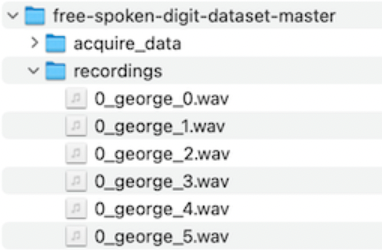



In [11]:
speakers = np.array(['george', 'jackson', 'lucas', 'nicolas', 'theo', 'yweweler'])

num_speakers = len(speakers)

curr_path = '/Users/waynesnyder/Documents/Teaching/CS583/Lectures and Demonstrations/Lecture 20 -- Intro to ML for Audio/'

dataset_dir = "free-spoken-digit-dataset-master/recordings/"

# print(os.path.join(curr_path,dataset_dir))
# os.listdir(os.path.join(curr_path,dataset_dir))

In [12]:
spoken_digit_data = []
spoken_digit_meta_data = []

#count = 0
for filename in os.listdir(dataset_dir):
    if(filename[0] == '.'):      # to avoid hidden files such as .DS_Store
        continue
    X, fileSR = librosa.load(dataset_dir+filename)
    if(fileSR != SR):           # error checking, to make sure all signals are SR = 22050
        print("Error:",filename, fileSR)
        
    spoken_digit_data.append(X)
    # separate components of filename of form:   digit_speaker_id-number.wav
    fns = filename.split('_')
    digit = int(fns[0])
    name = fns[1]
    idnum = int(fns[2][0])
    spoken_digit_meta_data.append( (digit,name,idnum) )

len(spoken_digit_data)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '_dl--eQ6VU.wav'

In [ ]:
# test
k = 1234
print(spoken_digit_meta_data[k])
displaySignal(spoken_digit_data[k])
Audio(spoken_digit_data[k],rate=fileSR)

### Data exploration 

The usual next step in any data science project, after reading in the data, is to
explore some of its features. 

Here we will examine the length of each signal, and then look at various useful features. 


In [10]:
# create matrix of features for the classifier

num_features = 7

spoken_digit_features = np.empty((len(spoken_digit_data),num_features))

for k in range(len(spoken_digit_data)):

    y = spoken_digit_data[k]

    # These functions compute a value for each frame, either from the audio 
    # samples y or from a spectrogram S.

    # By making the hop_length longer than the signal, we just grab the metric 
    # of the whole signal


    RMS = librosa.feature.rms(y,hop_length=len(y)+1)[0][0]
    #print('rms:',RMS)

    SC = librosa.feature.spectral_centroid(y,hop_length=len(y)+1)[0][0]
    #print('spectral_centroid:',SC)

    SB = librosa.feature.spectral_bandwidth(y,hop_length=len(y)+1)[0][0]
    #print('spectral_bandwidth:',SB)

    SCON = librosa.feature.spectral_contrast(y,hop_length=len(y)+1)[0][0]
    #print('spectral_contrast:',SCON)

    SF = librosa.feature.spectral_flatness(y,hop_length=len(y)+1)[0][0]
    #print('spectral_flatness:',SF)

    SR = librosa.feature.spectral_rolloff(y,hop_length=len(y)+1)[0][0]
    #print('spectral_rolloff:',SR)

    ZCR = librosa.feature.zero_crossing_rate(y,hop_length=len(y)+1)[0][0]
    #print('zero_crossing_rate:',ZCR)
    
    spoken_digit_features[k] = np.array([RMS,SC,SB,SCON,SF,SR,ZCR])

In [ ]:
# Try a histogram of each feature

feature_names = ['Root Mean Square Energy','Spectral Centroid','Spectral Bandwidth','Spectral Contrast',
                 'Spectral Flatness','Spectral Rolloff','Zero-Crossing Rate']

for k in range(num_features):    
    plt.figure(figsize=(12,4))
    plt.title(feature_names[k])
    plt.hist([fs[k] for fs in spoken_digit_features],bins=100, edgecolor='black')  # This gives the number of different signal lengths in the data set
    plt.show()


In [ ]:
#Try graphing two at a time

# feature_names = ['Root Mean Square Energy','Spectral Centroid','Spectral Bandwidth','Spectral Contrast',
#                  'Spectral Flatness','Spectral Rolloff','Zero-Crossing Rate']

f1 = 1
f2 = 2

plt.figure(figsize=(16,8))
plt.title("Comparison of "+feature_names[f1]+" and "+feature_names[f2])
plt.scatter([fs[f1] for fs in spoken_digit_features],[fs[f2] for fs in spoken_digit_features])
plt.xlabel(feature_names[f1])
plt.ylabel(feature_names[f2])
plt.show()

### Exploring the length of the signals (Important!)

In order to input the data to the CNN, we will need to convert the signals to mel spectrograms, but--important!--each such spectrogram has to have the same exact shape to be processed by the CNN, which means that **each signal 
has to have the exact same length.** 

Unfortunately, this is not true, as the next cell shows!

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Signal Lengths in Samples")
plt.hist([len(x) for x in spoken_digit_data],bins=100, edgecolor='black')  # This gives the number of different signal lengths in the data set
plt.show()

### Normalizing the amplitude and trimming the audio files

When processing any kind of data with a NN, it is important that the sample not have significant
differences that have nothing to do with the information we wish to process. For example, in
this data set, some speakers are louder than others, and so if we wish to identify speakers,
it will be too easy if the mean amplitude can be used to characterize each speaker!

In addition, the samples, as we just saw, have different lengths, some because there is silence at the beginning
and/or end of the clip. 
In order to preserve the most information in each sample, we will find the beginning and end of
the spoken digit, and then trim to a uniform length.  The beginning may be found by the onset detector,
and the end may be found by reversing the clip and finding the onset (which corresponds to the end of the digit). 

The very long samples (at the right end
of the histogram) we shall have to examine one by one to determine what is going on!

Some data files may need to be removed if they can not be transformed into a uniform length. 

We will add 0.25 secs of silence to the beginning and the end of the clip (to avoid problems with
finding onsets at the very beginning of a file, which can be problematic), and then find the onset
and the onset of the reversed signal. Finding the appropriate settings for the parameters in the
onset detector is critical here. 



First we explore the effect of various parameters to the onset detector, and come up with
a reasonable choice for finding the beginning and end of the spoken digit in the signal.  
We will also find the distribution of the resulting lengths, so we can choose a uniform
length for the inputs to the CNN. 


In [ ]:
# AmplitudeBasedOnsets(X,window_size=512,overlap=0.5,scale=10,
#                      height=None, prominence=None, distance=None, 
#                      displayAll=False):

lens = []

lst = [8,9,13,14,16,24,29,32,31,59]       # these were ones that seemed problematic as I tested

for k in range(len(spoken_digit_data)):                     
    x = spoken_digit_data[k]
    x1 = np.concatenate([np.zeros(int(SR//4)),normalize(x)])
    onsets = AmplitudeBasedOnsets(x1,window_size=128,hop_length=1, 
                                  scale=100,height=0.01, prominence=0.01,displayAll=False)
    offsets = AmplitudeBasedOnsets(x1[::-1],window_size=128,hop_length=1, 
                                   scale=100,height=0.01, prominence=0.01,displayAll=False)
    
    start = onsets[0]
    end = len(x1) - offsets[0]
    
    lens.append(end-start)
    
    if(k in lst):
        print(k,start,end)
        plt.figure(figsize=(12,4))
        plt.title("Signal with Onsets")
        plt.plot(x1)
        plt.plot([start,start],[-1,1],color='r')
        plt.plot([end,end],[-1,1],color='g')
        plt.show()
    
    
plt.figure(figsize=(16,6))
plt.title("Signal Lengths in Samples")
plt.hist(lens,bins=100, edgecolor='black')  # This gives the number of different signal lengths in the data set
plt.show()

Let's look at the clips that are longer than 0.75 seconds (16537 samples), and verify that
they do not have useful information at the end. 

In [ ]:
new_len = 16537
for k in range(len(lens)):
    if(lens[k] > new_len):
        print(spoken_digit_meta_data[k])
        displaySignal(spoken_digit_data[k])

Ok, it seems that 0.75 secs (16537 samples) is about the shortest we can make
the clips to preserve all the useful information. 


Next we will normalize the signals, then trim them by removing anything before the first onset and after the onset + 16537; if the result is not 16537 samples long, we will extend it with 0s.  

In [ ]:
spoken_digit_data_trimmed = []

for k in range(len(spoken_digit_data)):                     
    x = spoken_digit_data[k]
    x1 = np.concatenate([np.zeros(int(SR//4)),normalize(x)])
    onsets = AmplitudeBasedOnsets(x1,window_size=128,hop_length=1, 
                                  scale=100,height=0.01, prominence=0.01,displayAll=False)
    
    start = onsets[0]
    if(len(x1) > start+new_len):              # long enough, just trim
        x2 = x1[start:(start+new_len)]
    else:                                     # not long enough, add zeros to end
        x2 = np.concatenate( [ x1[start:], np.zeros(new_len - len(x1) + start)  ] )
        
    if(len(x2) != new_len):                   # to verify that all are length new_len
        print(k,spoken_digit_meta_data[k])
        break
        
    spoken_digit_data_trimmed.append(x2)
        

        
len(spoken_digit_data_trimmed)

### Transforming the audio files to mel spectrograms

We will input mel spectrograms to the CNN, so we need to convert our audio files to
that form. 


In [ ]:
mel_spectrograms = []
SR = 22050

for x in spoken_digit_data_trimmed:
    mel_spectrograms.append(librosa.feature.melspectrogram(x,SR,n_fft=512,hop_length=256, power=1))
    
a = mel_spectrograms

mel_spectrograms = np.asarray(mel_spectrograms)

b = mel_spectrograms 

mel_spect_shape = list(mel_spectrograms.shape)
mel_spect_shape.append(1)

mel_spectrograms = mel_spectrograms.reshape(mel_spect_shape)

In [ ]:
mel_spect_shape


In [ ]:
librosa.display.specshow(mel_spectrograms[150].reshape(mel_spect_shape[1:-1]),
                         y_axis='mel', x_axis='time')
plt.title('Mel Spectrogram')
plt.colorbar()

### Creating labels for the data set

We must provide a set of numeric labels for the data set.
Assuming we are trying to classify on the numbers spoken (as
opposed, say, to the speakers), we simply extract the first
number in each pair in the meta data:

In [ ]:
spoken_digit_meta_data[:10]

In [ ]:
labels = np.array( [ n for (n,_,_) in spoken_digit_meta_data] )

print(labels[:10])
len(labels)

## Separating Test Data

In [ ]:
mel_spectrograms.shape

In [ ]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(mel_spectrograms, labels, test_size=0.20, random_state=42)

X_valid,X_train = X_train_full[:30],X_train_full[30:]    # see p.298 in "Hands-On..."
y_valid,y_train = y_train_full[:30],y_train_full[30:]

In [ ]:
X_train_full.shape

In [ ]:
X_train.shape

In [ ]:
X_valid.shape

In [ ]:
X_test.shape

In [25]:
y_train_full.shape

NameError: name 'y_train_full' is not defined

In [ ]:
y_train.shape

In [ ]:
y_valid.shape

In [ ]:
y_test.shape

## Model Creation

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model = Sequential()

In [ ]:
mel_spect_shape[1:]

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=7, activation="relu", padding="same",input_shape=[128, 65, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"),
    keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same"),
    keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [ ]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

In [ ]:
4/0

In [ ]:
# #90% acc time convoluting
# model.add(Conv2D(input_shape=mel_spect_shape[1:],
#                 filters=128,kernel_size=(1,4),
#                 activation="relu"
#                 ))
# model.add(MaxPool2D(pool_size=(1,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(filters=32, kernel_size=(1,4),
#                 activation="relu"))
# model.add(MaxPool2D(pool_size=(1,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(filters=1, kernel_size=(1,4),
#                 activation="relu"))
# model.add(MaxPool2D(pool_size=(1,4)))
# model.add(Dropout(0.25))

# model.add(Flatten())

# model.add(Dense(128,activation="relu"))
# model.add(Dropout(0.3))

# model.add(Dense(64,activation="relu"))
# model.add(Dropout(0.3))

# model.add(Dense(7,activation="softmax"))

In [ ]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
EarlyStop = EarlyStopping(monitor="val_loss",patience=5)

In [ ]:
model.fit(X_train,y_train,epochs=60,batch_size=400,validation_data=(X_test,y_test))

In [ ]:
losses = model.history.history

plt.plot(losses["loss"])
plt.plot(losses["val_loss"])

plt.legend(["loss","validation loss"])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
predictions = np.argmax(model.predict(X_test), axis=-1)

In [ ]:
sns.heatmap(confusion_matrix(np.argmax(y_test,axis=1),predictions), robust=True,annot=True)

In [ ]:
print(classification_report(np.argmax(y_test,axis=1),predictions))

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
tf.config.list_physical_devices("GPU")